In [1]:
import json, csv, gzip
import pandas as pd
from collections import defaultdict
from collections import Counter
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.reciprocity import reciprocity
import numpy as np

In [35]:
high_recip = []
low_recip = []
h_recp = []
l_recp = []
high_scores = dict()
low_scores = dict()
source_csv = '/home/shruvp5/ICWSM/tenplus/'
years = [2016, 2017]
for year in years:
    for i in range(1, 13):
        if i == 1:
            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year-1) + '_' + str('{:02d}'.format(12)) + '_final.csv'
            csv3 = source_csv + str(year-1) + '_' + str('{:02d}'.format(11)) + '_final.csv'

        elif i == 2:

            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year) + '_' + str('{:02d}'.format(i-1)) + '_final.csv'
            csv3 = source_csv + str(year-1) + '_' + str('{:02d}'.format(12)) + '_final.csv'

        else:
            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year) + '_' + str('{:02d}'.format(i-1)) + '_final.csv'
            csv3 = source_csv + str(year) + '_' + str('{:02d}'.format(i-2)) + '_final.csv'

 
        curr = pd.read_csv(csv1, header=None, names=['index', 'author', 'count'])
        p1 = pd.read_csv(csv2, header=None, names=['index', 'author', 'count'])
        p2 = pd.read_csv(csv3, header=None, names=['index', 'author', 'count'])
        
        curr_high = curr.loc[curr['count'] >= np.percentile(np.array(curr['count']), 75), 'author'].tolist()
        curr_low = curr.loc[curr['count'] <= np.percentile(np.array(curr['count']), 25), 'author'].tolist()
        
        
        #commented for calculating p-value
        #h_recp = []
        #l_recp = []
        
        
        try:
            p1_high = p1.loc[p1['count'] >= np.percentile(np.array(p1['count']), 75), 'author'].tolist()
        except:
            p1_high = []

        
        try:
            p2_high = p2.loc[p2['count'] >= np.percentile(np.array(p2['count']), 75), 'author'].tolist()
        except:
            p2_high = []
            
            
        past_high = list(set(p1_high).union(set(p2_high)))
        
        fname = '/home/shruvp5/ICWSM/ties/' + str(year) + '_' + str('{:02d}'.format(i)) + '.csv'
        frame1 = pd.read_csv(fname, header=None, names=['author', 'subreddit', 'name', 'parent_id'])
        frame = frame1.loc[frame1['author']!='AutoModerator']
        nameset = set(frame['name'].tolist())
        parentset = set(frame['parent_id'].tolist())

        ids = nameset.intersection(parentset)
        Fcomments = frame[['author', 'name']]
        Frelation = frame[['name', 'parent_id']]
        comments= Fcomments.set_index('name').to_dict()['author']
        relation= Frelation.set_index('parent_id').to_dict()['name']

        D = nx.DiGraph()
        
        for interaction_id in ids:
            replier = comments[interaction_id]
            author = comments[relation[interaction_id]]
            #edgelist.append((author, replier))
            if (replier in curr_high or author in curr_high) and (replier in past_high or author in past_high):
                D.add_edge(replier, author, color='red')
            elif (replier in curr_low or author in curr_low) and (replier in past_high or author in past_high):
                D.add_edge(replier, author, color='green')
            else:
                D.add_edge(replier, author, color='blue')
                
        high_network = set(curr_high).union(set(D.nodes).difference(set(curr_low)))
        low_network = set(curr_low).union(set(D.nodes).difference(set(curr_high)))
        high_recp = reciprocity(D, high_network)
        low_recp = reciprocity(D, low_network)
        
        for author in curr_high:
            if author not in high_scores:
                try:
                    high_scores[author] = high_recp[author]
                except:
                    pass
            try:
                h_recp.append(high_recp[author])
            except:
                pass

        for author in curr_low:
            if author not in low_scores and author not in high_scores:
                try:
                    low_scores[author] = low_recp[author]
                except:
                    pass
            try:
                l_recp.append(low_recp[author])
            except:
                pass

        #sb.set(style="whitegrid")
        #sb.set(rc={'figure.figsize':(15,5)})
        #sb.distplot(h_recp, kde=False, rug=True)
        
        #sb.set(style="whitegrid")
        #sb.set(rc={'figure.figsize':(15,5)})
        #sb.distplot(l_recp, kde=False, rug=True)        
        
        high_recip.append(np.mean(h_recp))
        low_recip.append(np.mean(l_recp))


In [36]:
d = {'high':high_recip, 'low':low_recip}
df = pd.DataFrame(data=d)


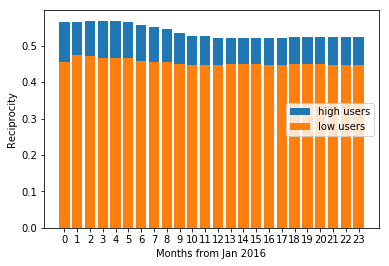

In [37]:
y_pos = np.arange(len(high_recip))

plt.bar(y_pos, high_recip, label='high users')
plt.bar(y_pos, low_recip, label='low users')
plt.xticks(y_pos)
plt.ylabel('Reciprocity')
plt.xlabel('Months from Jan 2016')
plt.legend(loc='right')
plt.show()

In [50]:
#all_scores = np.array(h_recp + l_recp)
all_scores = np.array(high_scores.values() + low_scores.values())

In [66]:
print np.array(high_recip).min()
print np.array(high_recip).max()
print np.array(high_recip).mean()
print np.array(high_recip).std()

0.520227326645
0.568638667009
0.538147208266
0.0192425013629


In [67]:
print np.array(low_recip).min()
print np.array(low_recip).max()
print np.array(low_recip).mean()
print np.array(low_recip).std()

0.445681562238
0.47396621818
0.453706038636
0.00838707732915


In [52]:
import scipy
from scipy import stats

m, v, s, k = stats.t.stats(10, moments='mvsk')

In [53]:
n, (smin, smax), sm, sv, ss, sk = stats.describe(all_scores)

In [54]:
sstr = '%-14s mean = %6.4f, variance = %6.4f, skew = %6.4f, kurtosis = %6.4f'
print(sstr % ('distribution:', m, v, s ,k))

distribution:  mean = 0.0000, variance = 1.2500, skew = 0.0000, kurtosis = 1.0000


In [55]:
print(sstr % ('sample:', sm, sv, ss, sk))

sample:        mean = 0.4538, variance = 0.0809, skew = -0.1482, kurtosis = -0.6820


In [56]:
print('t-statistic = %6.3f pvalue = %6.4f' %  stats.ttest_1samp(all_scores, m))

t-statistic = 194.442 pvalue = 0.0000


In [57]:
tt = (sm-m)/np.sqrt(sv/float(n))  # t-statistic for mean
pval = stats.t.sf(np.abs(tt), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))


t-statistic = 194.442 pvalue = 0.0000


In [58]:
print('KS-statistic D = %6.3f pvalue = %6.4f' % stats.kstest(all_scores, 't', (10,)))
print('KS-statistic D = %6.3f pvalue = %6.4f' % stats.kstest(all_scores, 'norm'))


KS-statistic D =  0.500 pvalue = 0.0000
KS-statistic D =  0.500 pvalue = 0.0000


In [59]:
print len(all_scores)

14852


In [60]:
print low_scores

{'y90210': 0.25, 'Dissociatve': 0.0, 'frothface': 0.7058823529411765, 'ghee99': 0.4444444444444444, 'oh_no_aliens': 0.46153846153846156, 'F_ckyou1234': 0.0, 'ARYAWILLKILLYOU': 0.3333333333333333, 'Jade_Cokeplate': 0.8571428571428571, 'verydesperatehere': 0.47058823529411764, 'DrHerbotico': 0.5, 'HD3D': 0.0, 'slowbrowsersarefunny': 0.5, 'Crown118': 0.0, 'herbalt420': 0.6666666666666666, '8bitfruy': 0.16666666666666666, 'Fernao': 0.6666666666666666, 'Altered_Amiba': 1.0, 'nliausacmmv': 0.4, 'ArchAntiAll': 0.6666666666666666, 'some_homeless_kid': 0.6896551724137931, 'The_Succatron': 0.0, 'Politicschmolitics': 0.6666666666666666, 'inh-uman': 0.6, 'nighthawk1961': 0.6666666666666666, 'dumbflame': 0.7272727272727273, 'Mastervaati': 0.0, 'peter-panocha': 0.0, 'IndecentLongExposure': 0.0, 'NEEK0': 0.5, 'rockyrainy': 0.5, 'watching98': 0.0, 'chasmoffaith': 0.4444444444444444, 'Dredgelord': 1.0, 'Moosetappropriate': 0.4878048780487805, 'gryphon_844': 0.5454545454545454, 'GetRekdAnally': 0.4, 'oa

In [63]:
with open('high_reciprocity.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in high_scores.items():
        writer.writerow([key, value])


In [64]:
with open('low_reciprocity.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in low_scores.items():
        writer.writerow([key, value])
